# Tutorial for Billiards-v0

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import contextlib

from moviepy.editor import ImageSequenceClip
from skimage.transform import resize

from utils import ObjectView, to_pickle, from_pickle

## Simulate
A simple implementation of 2D collision dynamics for N balls of equal mass in a square box.

In [2]:
def rotation_matrix(theta):  # contruct a rotation matrix
  return np.asarray([[np.cos(theta), -np.sin(theta)],
                    [np.sin(theta), np.cos(theta)]])

def rotate(x, theta):  # rotate vector x by angle theta
  R = rotation_matrix(theta)
  return (x.reshape(1,-1) @ R)[0]

def angle_between(v0, v1):  # the angle between two vectors
  return np.math.atan2(np.linalg.det([v0,v1]), np.dot(v0,v1))

def reflect(x, axis):  # reflect vector x about some other vector 'axis'
  new_xs = np.zeros_like(x)
  for i in range(x.shape[0]):
    theta = angle_between(x[i], axis[i])
    if np.abs(theta) > np.pi/2:
      theta = theta + np.pi
    new_xs[i] = rotate(-x[i], 2 * -theta)
  return new_xs
  
def collide_walls(xs, vs, r, dt):
  mask_low = np.where(xs < r)  # coordinates that are too low
  mask_high = np.where(xs > 1-r)  # coordinates that are too high
  vs[mask_low] *= -1  # rebound
  vs[mask_high] *= -1
  xs[mask_low] = 2*r - xs[mask_low]  # account for overshooting the wall
  xs[mask_high] = (1-r) - (xs[mask_high] - (1-r))  # easier to understand
  return xs, vs

def find_colliding_balls(xs, r):
  dist_matrix = ((xs[:,0:1] - xs[:,0:1].T)**2 + (xs[:,1:2] - xs[:,1:2].T)**2)**.5
  dist_matrix[np.tril_indices(xs.shape[0])] = np.inf  # we only care about upper triangle
  body1_mask, body2_mask = np.where(dist_matrix < 2*r)  # select indices of colliding balls
  return body1_mask, body2_mask

def collide_balls(new_xs, vs, r, dt):
  body1_mask, body2_mask = find_colliding_balls(new_xs, r)
  
  # if at least one pair of balls are colliding
  if len(body1_mask) > 0:
    radii_diff = new_xs[body2_mask] - new_xs[body1_mask]  # diff. between radii

    prev_xs = new_xs - vs * dt  # step backward in time
    prev_radii_diff = prev_xs[body2_mask] - prev_xs[body1_mask]

    # if the pair of balls are getting closer to one another
    if np.sum(radii_diff**2) < np.sum(prev_radii_diff**2):
      vs_body1, vs_body2 = vs[body1_mask], vs[body2_mask]  # select the two velocities
      v_com = (vs_body1 + vs_body2) / 2   # find the velocity of the center of masses (assume m1=m2)
      vrel_body1 = vs_body1 - v_com  # we care about relative velocities of the ball

      reflected_vrel_body1 = reflect(vrel_body1, radii_diff)
      vs[body1_mask] = reflected_vrel_body1 + v_com  # rotate velocities (assumes m1=m2)
      vs[body2_mask] = -reflected_vrel_body1 + v_com # symmetry of a perfect collision

  return new_xs, vs

def init_balls(r, num_balls=3, make_1d=False, normalize_v=False):
  x0 = np.random.rand(num_balls, 2) * (1-2*r) + r  # balls go anywhere in box
  v0 = (.75 * np.random.randn(*x0.shape)).clip(-1.2, 1.2)
  if make_1d:
    x0[:,0] = 0.5 ; v0[:,0] = 0  # center and set horizontal velocity to 0
  if normalize_v:
    v0 /= np.linalg.norm(v0, axis=1, keepdims=True)  # velocities start out normalized
  mask, _ = find_colliding_balls(x0, r)  # recursively re-init if any balls overlap
  return init_balls(r, num_balls, make_1d) if len(mask) > 0 else np.concatenate((x0, v0),axis=-1)

def simulate_balls(r=8e-2, dt=2e-2, num_steps=50, num_balls=2, init_state=None, make_1d=False,
                   normalize_v=False, verbose=False):
  start_state = init_balls(r, num_balls, make_1d, normalize_v) if init_state is None else init_state
  x0, v0 = start_state[:,:2], start_state[:,2:]
  # x0, v0 = np.flip(x0, axis=0), np.flip(v0, axis=0)  # debugging: simulation should be invariant to this

  curr_x, curr_v = x0, v0
  xs, vs = [x0.copy()], [v0.copy()]
  if verbose: print('initial energy: ', (curr_v**2).sum())
  for i in range(num_steps-1):
    new_xs = xs[-1] + curr_v * dt
    new_xs, curr_v = collide_walls(new_xs, curr_v, r, dt)
    new_xs, curr_v = collide_balls(new_xs, curr_v, r, dt)
    xs.append(new_xs.copy())
    vs.append(curr_v.copy())
  if verbose: print('final energy: ', (curr_v**2).sum())
  return np.concatenate([np.stack(xs), np.stack(vs)], axis=-1)

## Plot
Input a list of coordinates and get out a sequence of frames that can be turned into a movie. Intended to be rather efficient.

### We'll begin by plotting a still frame

In [3]:
def render_masks(centers, r=.15, side=100, render_target=True):
  '''Renders the object masks for the billiards environment.
  Note: 'centers' is a tensor of dims [time, balls, x_y_vx_vy_coords]'''
  has_time_dim = True
  if len(centers.shape) == 2:
    centers = centers[None,...]
    has_time_dim = False
  x = np.linspace(0, 1.0, side)[None, None, :]  # [time, balls, x]
  y = np.linspace(0, 1.0, side)[None, None, :]  # [time, balls, y]
  diff_x, diff_y = (x-centers[...,0:1])/r, (y-centers[...,1:2])/r
  diff_x, diff_y = diff_x[:,:, None, :], diff_y[:, :, :, None]
  masks = (diff_x**2+diff_y**2 < 1.0).astype(bool)  # mask is OFF in circle
  if render_target:
    target_mask = np.copy(masks[:,:1]) * False
    k = int(.2*side)
    target_mask[..., :k, -k:] = True
    masks = np.concatenate([masks, target_mask], axis=1)
  return masks if has_time_dim else masks.squeeze(0)

@contextlib.contextmanager
def temp_seed(seed):
    state = np.random.get_state()
    np.random.seed(seed)
    try:
        yield
    finally:
        np.random.set_state(state)
        
def project_to_rgb(x, size=3, seed=10):
  '''Projects the last dimension to size(3).'''
  with temp_seed(seed): # make this section deterministically random
    P = np.random.rand(x.shape[-1], size)
    P /= np.linalg.norm(P,axis=-2, keepdims=True)
    P *= 255
  return np.einsum('...i,ij->...j', x, P).astype(np.int16)

(2, 2, 2)
(2, 3, 100, 100)


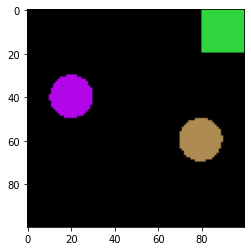

In [4]:
centers = np.asarray([[[.2,.4],[.8,.6]], # [time, balls, space] (t=0)
                     [[.25,.45],[.75,.55]]]) # (t=1)
print(centers.shape)
masks = render_masks(centers, r=.1)
print(masks.shape)
masks = masks[0].transpose(1,2,0)
im = project_to_rgb(masks)
plt.imshow(im, cmap='gray')
plt.show()

### Now we'll stitch the frames together to make a movie

In [5]:
def get_dataset_args(as_dict=False):
    arg_dict = {'num_samples': 10000,
                'train_split': 0.9,
                'time_steps': 45,
                'num_balls': 2,
                'r': 1e-1,
                'dt': 1e-2,
                'seed': 0,
                'make_1d': False,
                'verbose': True,
                'side': 32,  # side lenth, in pixels
                'use_pixels': False}
    return arg_dict if as_dict else ObjectView(arg_dict)
    
args = get_dataset_args()
xs = simulate_balls(args.r, args.dt, 5*args.time_steps, args.num_balls,
                    make_1d=args.make_1d, verbose=False)
masks = render_masks(xs, r=args.r, side=args.side)

# frameseq = [f*255 for f in frames[...,None].repeat(3,-1)] # add RGB channel
frameseq = [f.repeat(9, axis=0).repeat(9, axis=1) for f in project_to_rgb(masks.transpose(0,2,3,1))]
ImageSequenceClip(frameseq, fps=70).ipython_display()

t:   5%|▍         | 11/225 [00:00<00:01, 109.97it/s, now=None]

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


## Make into an RL environment
The agent gets to apply a force to the purple ball every so often. The goal is to get the yellow ball into the top right corner.

In [13]:
class Billiards:
  def __init__(self, args, use_pixels=False, action_is_force=True):
    assert not args.make_1d, "We only support 2D sims"
    self.make_1d = False
    self.r = args.r
    self.num_balls = args.num_balls
    self.dt = args.dt
    self.seed = args.seed
    self.args = args
    self.use_pixels = use_pixels
    self.side = args.side
    self.action_is_force = action_is_force # otherwise it's a new velocity
    self.reset()
    
  def reset(self):
    state = init_balls(self.r, self.num_balls, self.make_1d, normalize_v=False)
    state[1,2:] = 0  # state has shape [balls, xyvxvy]
    self.state = state
    self.x, self.v = state[:,:2], state[:,2:]

  def step(self, action=None, num_steps=5, tau=1.2):
    if action is not None and action.sum() != 0:
        assert action.shape[0] == 2
        action = action.clip(-tau, tau) # maximum force that can be applied
        if self.action_is_force:
            self.state[1,2:] += action  # given v' = a*t + v & F=ma, we set m=t=1 and get v' = F + v
        else:
            self.state[1,2:] = action   # treat the action as the new velocity directly
    
    state = simulate_balls(self.r, self.dt, num_steps, self.num_balls, self.state,
                           self.make_1d, normalize_v=False, verbose=False)[-1]
    # state has shape [balls, xyvxvy]
    self.state = state
    self.x, self.v = state[:,:2], state[:,2:]
    
    done = (self.x[0,0] > 0.8) and (self.x[0,1] < 0.2) # ball 0 is in upper right corner
    reward = 1. if done else 0.
    info = {'position': self.x.flatten(), 'velocity': self.v}
    
    if self.use_pixels:
      masks = render_masks(state, r=self.r, side=3*self.side).transpose(1,2,0) # masks has shape [x,y,num_balls]
      obs = project_to_rgb(masks)
      obs = resize(obs.astype(float), (self.side, self.side, 3)).astype(np.int16)
      if done:
        obs[:1] = obs[-1:] = obs[:,:1] = obs[:,-1:] = 100  # border color changes when reward is received
    else:
      obs = self.x.flatten()
    # obs has shape [x, y, rgb] if use_pixels, otherwise shape [balls * xyvxvy]
    return obs, reward, done, info

In [14]:
# use Cartesian coordinate obserations
np.random.seed(0)
env = Billiards(args)
all_obs = []
for i in range(45):
  obs, reward, done, info = env.step()
  all_obs.append(obs)
all_obs = np.stack(all_obs)
print(all_obs.shape)

(45, 4)


In [15]:
# use pixel observations
np.random.seed(0)
env = Billiards(args, use_pixels=True)
# env.state[1,2:] = 0
all_obs = []
all_r = []
for i in range(45):
  action = np.array([.2,-.8]) if i==10 else None
  obs, reward, done, info = env.step(action)
  all_obs.append(obs) ; all_r.append(reward)
all_obs = np.stack(all_obs)
print(all_obs.shape)

frameseq = [f.repeat(9, axis=0).repeat(9, axis=1) for f in all_obs]
ImageSequenceClip(frameseq, fps=70./10).ipython_display()

(45, 32, 32, 3)
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4

Moviepy - Done !
Moviepy - video ready __temp__.mp4


## Code for generating a dataset
The goal here is to make a large dataset of dynamics observations. We'll apply zero force to the purple ball at all timesteps except the fourth. Later we will train a model to plan over possible futures in order to select the proper amount of force to apply to the purple "cue" ball in order to get the other ball to the top right corner.

### We'll begin by writing several modular functions and timing them

In [19]:
def make_trajectory(env, args):
  obs, coords, actions = [], [], []
  next_action = None
  for i in range(args.time_steps):
    o, r, d, info = env.step(next_action)
    next_action = 1.2 * (2*np.random.rand((2))-1) if i==3 else np.zeros((2))
    obs.append(o) ; coords.append(info['position']) ; actions.append(next_action.copy())
  return np.stack(obs), np.stack(coords), np.stack(actions)

def make_dataset(args, **kwargs):
  if args.use_pixels and args.verbose:
    print('When Sam profiled this code, it took 0.15 sec/trajectory.')
    print('\t-> Expect it to take ~25 mins to generate 10k samples.')
    
  np.random.seed(args.seed)
  env = Billiards(args, use_pixels=args.use_pixels)
  xs, cs = [], []  # xs, which may be pixels, and cs, which are always coordinates, acts=actions
  for i in range(args.num_samples):
    x, c, a = make_trajectory(env, args)
    c = np.concatenate([c,a], axis=-1)
    if not args.use_pixels:
        x = c  # if making a cood dataset, include action info in observation
    xs.append(x) ; cs.append(c) ; env.reset()
    if args.verbose and (i+1)%10==0:
      print('\rdataset {:.3f}% built'.format((i+1)/args.num_samples * 100), end='', flush=True)

  xs, cs = [np.stack(v).swapaxes(0,1) for v in [xs, cs]]
  split_ix = int(args.num_samples*args.train_split) # train / test split
  dataset = {'x': xs[:, :split_ix], 'x_test': xs[:, split_ix:],
            'dt': args.dt, 'r': args.r, 'num_balls': args.num_balls}
  if args.use_pixels:
    dataset['c'] = cs[:, :split_ix]
    dataset['c_test'] = cs[:, split_ix:]
  else:
    dataset['y'] = dataset['x'][...,:8]  # targets are same as inputs, except we drop the actions
    dataset['y_test'] = dataset['x_test'][...,:8]
  return dataset

# we'll cache the dataset so that it doesn't have to be rebuild every time
def load_dataset(args, path=None, regenerate=False, **kwargs):
    path = './billiards.pkl' if path is None else path
    try:
      if regenerate:
          raise ValueError("Regenerating dataset") # yes this is hacky
      dataset = from_pickle(path)
      if args.verbose:
          print("Successfully loaded data from {}".format(path))
    except:
      if args.verbose:
          print("Did or could not load data from {}. Rebuilding dataset...".format(path))
      dataset = make_dataset(args, **kwargs)
      to_pickle(dataset, path)
    return dataset

In [20]:
args = get_dataset_args()
args.num_samples = 100
args.use_pixels = True
import time ; t0 = time.time()
dataset = load_dataset(args, regenerate=True)
print("Made/loaded the dataset; it took {:.2e}s\n".format(time.time()-t0))

# visualize the 20th trajectory in the dataset
print(dataset['x'].shape)  # shape (time, batch, height, width, rgb)
frameseq = [f.repeat(8, axis=0).repeat(8, axis=1) for f in dataset['x'][:,21]]
ImageSequenceClip(frameseq, fps=70./10).ipython_display()

Did or could not load data from ./billiards.pkl. Rebuilding dataset...
When Sam profiled this code, it took 0.15 sec/trajectory.
	-> Expect it to take ~25 mins to generate 10k samples.
dataset 100.000% built

Made/loaded the dataset; it took 1.85e+01s

(45, 90, 32, 32, 3)
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4

Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [21]:
dataset['c'][:20,0,:].round(1)

array([[ 0.9,  0.7,  0.5,  0.7,  0. ,  0. ],
       [ 0.9,  0.7,  0.5,  0.7,  0. ,  0. ],
       [ 0.9,  0.7,  0.5,  0.7,  0. ,  0. ],
       [ 0.9,  0.6,  0.5,  0.7, -0.6,  0.7],
       [ 0.9,  0.6,  0.4,  0.8,  0. ,  0. ],
       [ 0.9,  0.6,  0.4,  0.8,  0. ,  0. ],
       [ 0.9,  0.6,  0.4,  0.8,  0. ,  0. ],
       [ 0.8,  0.5,  0.4,  0.8,  0. ,  0. ],
       [ 0.8,  0.5,  0.4,  0.9,  0. ,  0. ],
       [ 0.8,  0.5,  0.3,  0.9,  0. ,  0. ],
       [ 0.8,  0.5,  0.3,  0.9,  0. ,  0. ],
       [ 0.8,  0.4,  0.3,  0.9,  0. ,  0. ],
       [ 0.8,  0.4,  0.3,  0.8,  0. ,  0. ],
       [ 0.8,  0.4,  0.2,  0.8,  0. ,  0. ],
       [ 0.8,  0.4,  0.2,  0.8,  0. ,  0. ],
       [ 0.8,  0.3,  0.2,  0.8,  0. ,  0. ],
       [ 0.8,  0.3,  0.2,  0.7,  0. ,  0. ],
       [ 0.7,  0.3,  0.2,  0.7,  0. ,  0. ],
       [ 0.7,  0.3,  0.1,  0.7,  0. ,  0. ],
       [ 0.7,  0.2,  0.1,  0.7,  0. ,  0. ]])

### Now we are going to make the full-size dataset

In [22]:
# def get_dataset_args(as_dict=False):
#     arg_dict = {'num_samples': 10000,
#                 'train_split': 0.9,
#                 'time_steps': 45,
#                 'num_balls': 2,
#                 'r': 1e-1,
#                 'dt': 1e-2,
#                 'seed': 0,
#                 'make_1d': False,
#                 'verbose': True,
#                 'side': 32,  # side lenth, in pixels
#                 'use_pixels': False}
#     return arg_dict if as_dict else ObjectView(arg_dict)

# args = get_dataset_args()
# args.num_samples = 100
# args.use_pixels = True
# import time ; t0 = time.time()
# dataset = make_dataset(args)
# print(time.time()-t0)

In [23]:
# def plot_frame(fig, frames, i):
#   plt.imshow(frames[i])
#   plt.gca().axis("off")
#   make_square_axes(plt.gca())

# def make_square_axes(ax):
#   ax.set_aspect(1 / ax.get_data_ratio())

# def make_video(frames, path, interval=700, **kwargs):
#   fig = plt.figure(figsize=[3.25, 3.25], dpi=100)
#   camera = Camera(fig)
#   for i in range(frames.shape[0]):
#     plot_frame(fig, frames, i)
#     plt.tight_layout() ; camera.snap()
#   anim = camera.animate(blit=True, interval=interval, **kwargs)
#   anim.save(path)